In [ ]:
!pip install Pillow opencv-python numpy tensorflow

# Crop and resize images

The images are 3552x3552 pixels and contain a lot of empty space at the edges. Here we crop the images to 2048x2048 toward the center. Then they are resized to 64x64.

In [ ]:
from PIL import Image
import os
from pprint import pprint

dirs = [ (f'.\\data\\raw_data\\{num}', f'.\\data\\processed_64\\{num}') for num in range(16) ]

pprint(dirs)
for (in_dir, out_dir) in dirs:
    os.makedirs(out_dir, exist_ok=True)

original_size = 3552
crop_size = 2048
target_size = 64
max_files = 60 # We want the same number of images of each ball

In [ ]:
left = (original_size - crop_size) // 2
top = (original_size - crop_size) // 2
right = (original_size + crop_size) // 2
bottom = (original_size + crop_size) // 2

for (in_dir, out_dir) in dirs:
    files = os.listdir(in_dir)
    print(f"Processing {in_dir} ...")

    counter = 0
    for filename in files[:max_files]:
        if filename.lower().endswith(".jpg"):
            counter += 1
            # Open the image
            img_path = os.path.join(in_dir, filename)
            output_path = os.path.join(out_dir, filename)
            
            Image.open(img_path
                ).crop((left, top, right, bottom)
                ).resize((target_size, target_size), Image.Resampling.LANCZOS
                ).save(output_path)

            # print(f"Cropped and saved: {output_path} ({counter} of {max_files})")

# Split the data into training, validation and testing datasets

We have 960 images (60 of each class). We will split these into

720 training images (75 %)\
80 validation images (8.33 %)\
160 testing images (16.67 %)

In [1]:
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf

data_dir = './data/processed_64'
batch_size = 25
img_width = 64
img_height = 64

dataset = keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

class_names = dataset.class_names # ['0', '1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']

image_batches = []
label_batches = []

for images, labels in dataset:
    image_batches.append(images)
    label_batches.append(labels)

X = np.concatenate(image_batches)
y = np.concatenate(label_batches)

print("Splitting data into training, validation and testing datasets...")

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size = 0.25, random_state = 0)

X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size = (2/3), random_state = 0)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_val", X_val.shape)
print("y_val", y_val.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

Found 960 files belonging to 16 classes.
Splitting data into training, validation and testing datasets...
X_train (720, 64, 64, 3)
y_train (720,)
X_val (80, 64, 64, 3)
y_val (80,)
X_test (160, 64, 64, 3)
y_test (160,)


# PCA decomposition

We use PCA decomposition to decrease the number of features. First we calculate the cumulative explained variance of PCA components for each of the image color channels, averaged over the training dataset. We choose the number of PCA components based on the average to preserve as much of the explained variance as possible, while reducing the number of components.

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Initialize variables for cumulative explained variance ratios
embed_size = 32
cumulative_variances = [np.zeros(embed_size),np.zeros(embed_size),np.zeros(embed_size)]

# Loop over all images in the X_train dataset
counter = 0
for img in X_train:
    # print(f"Processing {counter} of {len(X_train)}")
    counter = counter + 1
    
    img = img.astype("uint8")
    blue, green, red = cv2.split(img)
    blue = blue / 255
    green = green / 255
    red = red / 255

    pca_b, pca_g, pca_r = [PCA(n_components=embed_size) for i in range(3)]
    
    reduced_blue = pca_b.fit(blue)  
    reduced_green = pca_g.fit(green)  
    reduced_red = pca_r.fit(red)  

    cumulative_variances[0] += pca_b.explained_variance_ratio_
    cumulative_variances[1] += pca_g.explained_variance_ratio_
    cumulative_variances[2] += pca_r.explained_variance_ratio_

# Average the explained variance ratios over the entire dataset
avg_variance_blue = cumulative_variances[0] / len(X_train)
avg_variance_green = cumulative_variances[1] / len(X_train)
avg_variance_red = cumulative_variances[2] / len(X_train)

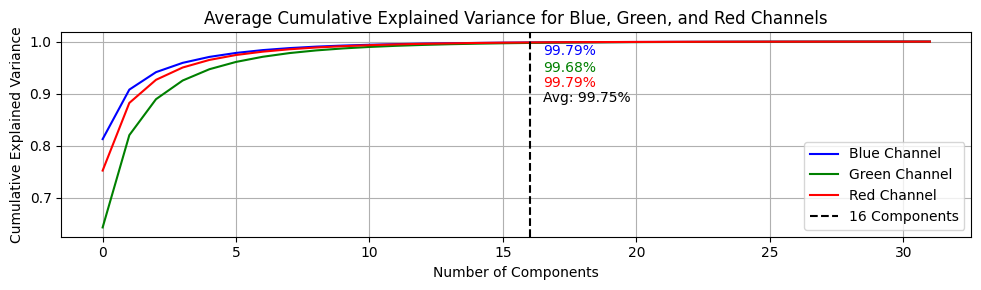

In [9]:
# Calculate the total explained variance for the first 16 components
selected_embed_size = 16

# Find the variance explained by the first 16 components for each channel
variance_blue = np.sum(avg_variance_blue[:selected_embed_size])
variance_green = np.sum(avg_variance_green[:selected_embed_size])
variance_red = np.sum(avg_variance_red[:selected_embed_size])

# Convert to percentage
variance_blue_percentage = variance_blue * 100
variance_green_percentage = variance_green * 100
variance_red_percentage = variance_red * 100
variance_avg_percentage = ((variance_blue + variance_green + variance_red) / 3) * 100

# Plot the cumulative explained variance for all channels on the same plot
plt.figure(figsize=(10, 3))
plt.title("Average Cumulative Explained Variance for Blue, Green, and Red Channels")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

# Plot the averaged cumulative explained variance for each channel
plt.plot(np.cumsum(avg_variance_blue), label='Blue Channel', color='blue')
plt.plot(np.cumsum(avg_variance_green), label='Green Channel', color='green')
plt.plot(np.cumsum(avg_variance_red), label='Red Channel', color='red')

# Add a vertical line at 16 components
plt.axvline(x=16, color='black', linestyle='--', label='16 Components')

# Annotate the variances at x=16
plt.text(16 + 0.5, np.cumsum(avg_variance_blue)[15] - 0.03, f'{variance_blue_percentage:.2f}%', 
         color='blue', fontsize=10, verticalalignment='bottom')
plt.text(16 + 0.5, np.cumsum(avg_variance_green)[15] - 0.06, f'{variance_green_percentage:.2f}%', 
         color='green', fontsize=10, verticalalignment='bottom')
plt.text(16 + 0.5, np.cumsum(avg_variance_red)[15] - 0.09, f'{variance_red_percentage:.2f}%', 
         color='red', fontsize=10, verticalalignment='bottom')
plt.text(16 + 0.5, np.cumsum(avg_variance_red)[15] - 0.12, f'Avg: {variance_avg_percentage:.2f}%', 
         color='black', fontsize=10, verticalalignment='bottom')

# Add a legend
plt.legend(loc='lower right')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


From the plot above we see that 16 PCA components should be sufficient for our use case.
Here we visualize how different number of PCA components reduce the image quality.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


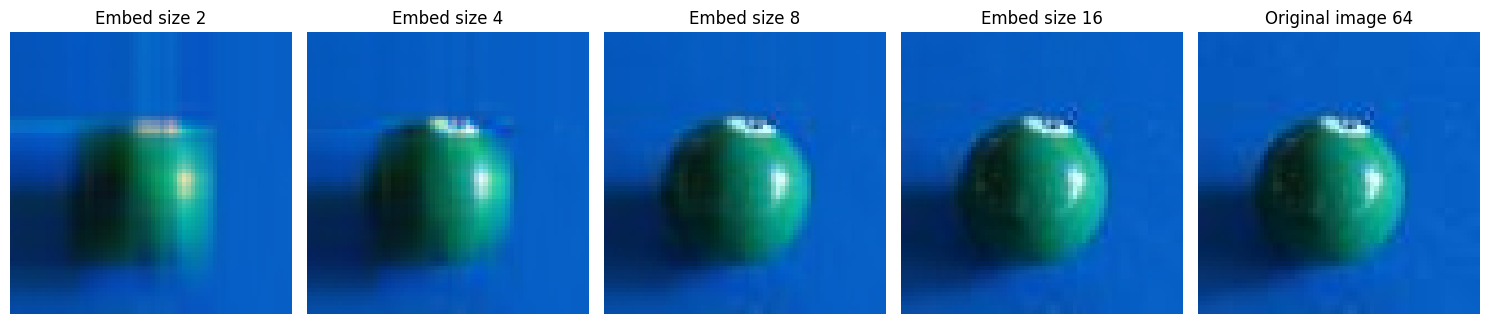

In [49]:
from random import randrange
embed_sizes=[2, 4, 8, 16]

fig, axs = plt.subplots(1, len(embed_sizes) + 1, figsize=(15, 15))

image = X_train[randrange(0, len(X_train))]

for i, selected_embed_size in enumerate(embed_sizes):
    # Select a random image from X_train
    img = image.astype("uint8")
    blue, green, red = cv2.split(img)
    blue = blue / 255
    green = green / 255
    red = red / 255

    # PCA for each channel
    pca_b = PCA(n_components=selected_embed_size)
    trans_pca_b = pca_b.fit(blue).transform(blue)

    pca_g = PCA(n_components=selected_embed_size)
    trans_pca_g = pca_g.fit(green).transform(green)

    pca_r = PCA(n_components=selected_embed_size)
    trans_pca_r = pca_r.fit(red).transform(red)

    # Inverse transformation to get reduced images
    b_arr = pca_b.inverse_transform(trans_pca_b)
    g_arr = pca_g.inverse_transform(trans_pca_g)
    r_arr = pca_r.inverse_transform(trans_pca_r)

    img_reduced = cv2.merge((b_arr, g_arr, r_arr))

    # Plot original and reduced images
    axs[i].imshow(img_reduced)
    axs[i].set_title(f"Embed size {selected_embed_size}")
    axs[i].axis('off')  # Turn off axis

axs[4].imshow(image.astype("uint8"))
axs[4].set_title(f"Original image 64")
axs[4].axis('off')  # Turn off axis

# Show the plots
plt.tight_layout()
plt.show()

# SVC

In [62]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
selected_embed_size = 16

def prepare_X(X, n_components=selected_embed_size, flatten = True):
    n_samples, h, w, channels = X.shape
    # 720, 64, 64, 3

    # Split into color channels
    blue_channel = X[:, :, :, 0]
    green_channel = X[:, :, :, 1]
    red_channel = X[:, :, :, 2]

    print("b, g, r shapes", np.shape(blue_channel), np.shape(green_channel), np.shape(red_channel))

    pca_b, pca_g, pca_r = [PCA(n_components=n_components) for _ in range(3)]

    transformed_blue = [pca_b.fit_transform(im) for im in blue_channel]
    transformed_green = [pca_g.fit_transform(im) for im in green_channel]
    transformed_red = [pca_r.fit_transform(im) for im in red_channel]
    # Shape is now (720, 64, 16) for each channel

    print("transformed shapes", np.shape(transformed_blue), np.shape(transformed_green), np.shape(transformed_red))

    X_pca = np.stack((transformed_blue, transformed_green, transformed_red), axis=-1)  # Shape: (720, 64, 16, 3)
    print("xpca_shape", X_pca.shape)
    
    if (flatten):   return X_pca.reshape(n_samples, -1)
    else:           return X_pca



In [ ]:

print("preparing X_train", X_train.shape)
X_train_pca = prepare_X(X_train)
print(X_train_pca.shape)

print("preparing X_val", X_val.shape)
X_val_pca = prepare_X(X_val)
print(X_val_pca.shape)

print("preparing X_test", X_test.shape)
X_test_pca = prepare_X(X_test)
print(X_test_pca.shape)

model = SVC(probability=True).fit(X_train_pca , y_train)



In [6]:
from sklearn.svm import SVC

X_tr = X_train.reshape(720, -1)
X_va = X_val.reshape(80, -1)
X_te = X_test.reshape(160, -1)

model = SVC(probability=True).fit(X_tr, y_train)

In [15]:
from sklearn import metrics

# X_train_pca = X_tr
# X_val_pca = X_va
# X_test_pca = X_te

y_pred_train = model.predict(X_train_pca)
y_pred_train_probability = model.predict_proba(X_train_pca)

y_pred_val = model.predict(X_val_pca)
y_pred_val_probability = model.predict_proba(X_val_pca)

y_pred_test = model.predict(X_test_pca)
y_pred_test_probability = model.predict_proba(X_test_pca)

train_log_loss = metrics.log_loss(y_train, y_pred_train_probability)
train_hinge_loss = metrics.hinge_loss(y_train, y_pred_train_probability)
train_acc = metrics.accuracy_score(y_train, y_pred_train)
train_pr = metrics.precision_score(y_train, y_pred_train, average='macro')
train_re = metrics.recall_score(y_train, y_pred_train, average='macro')
train_f1 = metrics.f1_score(y_train, y_pred_train, average='macro')

valid_log_loss = metrics.log_loss(y_val, y_pred_val_probability)
valid_hinge_loss = metrics.hinge_loss(y_val, y_pred_val_probability)
valid_acc = metrics.accuracy_score(y_val, y_pred_val)
valid_pr = metrics.precision_score(y_val, y_pred_val, average='macro')
valid_re = metrics.recall_score(y_val, y_pred_val, average='macro')
valid_f1 = metrics.f1_score(y_val, y_pred_val, average='macro')

test_log_loss = metrics.log_loss(y_test, y_pred_test_probability)
test_hinge_loss = metrics.hinge_loss(y_test, y_pred_test_probability)
test_acc = metrics.accuracy_score(y_test, y_pred_test)
test_pr = metrics.precision_score(y_test, y_pred_test, average='macro')
test_re = metrics.recall_score(y_test, y_pred_test, average='macro')
test_f1 = metrics.f1_score(y_test, y_pred_test, average='macro')


In [ ]:
print(f"Train Log Loss = {train_log_loss:.4f}")
print(f"Train Hinge Loss = {train_hinge_loss:.4f}")
print(f"Train Accuracy = {train_acc * 100:.2f}%")
print(f"Train Precision = {train_pr:.4f}")
print(f"Train Recall = {train_re:.4f}")
print(f"Train F1-Score = {train_f1:.4f}")
print('-' * 20)

print(f"Valid Log Loss = {valid_log_loss:.4f}")
print(f"Valid Hinge Loss = {valid_hinge_loss:.4f}")
print(f"Valid Accuracy = {valid_acc * 100:.2f}%")
print(f"Valid Precision = {valid_pr:.4f}")
print(f"Valid Recall = {valid_re:.4f}")
print(f"Valid F1-Score = {valid_f1:.4f}")
print('-' * 20)

print(f"Test Log Loss = {test_log_loss:.4f}")
print(f"Test Hinge Loss = {test_hinge_loss:.4f}")
print(f"Test Accuracy = {test_acc * 100:.2f}%")
print(f"Test Precision = {test_pr:.4f}")
print(f"Test Recall = {test_re:.4f}")
print(f"Test F1-Score = {test_f1:.4f}")


# SVC with PCA results

| Metric              | Train    | Valid    | Test     |
|---------------------|----------|----------|----------|
| Log Loss            | 0.5153   | 0.6615   | 0.7971   |
| Hinge Loss          | 0.4882   | 0.5621   | 0.6451   |
| Accuracy            | 91.53%   | 80.00%   | 70.00%   |
| Precision           | 0.9252   | 0.8156   | 0.7180   |
| Recall              | 0.9155   | 0.7646   | 0.7040   |
| F1-Score            | 0.9169   | 0.7684   | 0.6985   |

pca preparation of datasets + model training time: 11 s
prediction time: 3 s


# SVC without PCA results

| Metric              | Train    | Valid    | Test     |
|---------------------|----------|----------|----------|
| Log Loss            | 0.4375   | 0.5468   | 0.5665   |
| Hinge Loss          | 0.4456   | 0.5346   | 0.5264   |
| Accuracy            | 89.03%   | 85.00%   | 81.25%   |
| Precision           | 0.8966   | 0.8337   | 0.8205   |
| Recall              | 0.8909   | 0.8262   | 0.8086   |
| F1-Score            | 0.8887   | 0.8071   | 0.7997   |

model training time: 4 min 47 s
prediction time 2 min 36 s




# SVC with vs. without PCA: Performance Summary

## Accuracy Comparison

| Dataset   | With PCA | Without PCA | Change         |
|-----------|----------|-------------|----------------|
| Train     | 91.53%   | 89.03%      | -2.50%         |
| Validation| 80.00%   | 85.00%      | +5.00%         |
| Test      | 70.00%   | 81.25%      | +11.25%        |

- **Train Accuracy** drops by 2.5% without PCA.
- **Validation Accuracy** improves by 5% without PCA.
- **Test Accuracy** shows the most significant improvement, increasing by 11.25% without PCA.

## Training and Prediction Time

| Task              | With PCA   | Without PCA   | Difference        |
|-------------------|------------|---------------|-------------------|
| Training Time      | 11 seconds | 4 min 47 sec  | ~26x longer       |
| Prediction Time    | 3 seconds  | 2 min 36 sec  | ~52x longer       |

- **Training Time** without PCA takes over 26 times longer.
- **Prediction Time** without PCA is over 50 times longer than with PCA.

## Conclusion

While the **accuracy improves** significantly when **PCA is not used**, the **computational cost** in terms of training and prediction time is much higher. The decision to use PCA depends on whether the focus is on achieving higher accuracy or on minimizing training and prediction times.


# Data augmentation

In [2]:
from keras import layers
import tensorflow as tf
import numpy as np

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

normalization_layer = keras.layers.Rescaling(1./255) # Rescale RGB values from 0..255 to floats in 0..1

augmentation_layer = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomBrightness(0.05)
])

batch_size = 50
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(
    lambda x, y: (augmentation_layer(x), y)).map(
    lambda x, y: (normalization_layer(x), y)
    ).shuffle(buffer_size=len(X_train), seed=0, reshuffle_each_iteration=True
    ).batch(batch_size
    ).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(
    lambda x, y: (normalization_layer(x), y)
    ).batch(batch_size
    ).prefetch(buffer_size=AUTOTUNE)
 
test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
    ).batch(batch_size
    ).prefetch(buffer_size=AUTOTUNE)

# Create and train the CNN

In [6]:
num_classes = 16
model = keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [7]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1235 - loss: 2.7284 - val_accuracy: 0.1375 - val_loss: 2.5143
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3716 - loss: 2.1513 - val_accuracy: 0.3875 - val_loss: 1.7844
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5547 - loss: 1.3331 - val_accuracy: 0.7250 - val_loss: 1.0101
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6712 - loss: 0.8971 - val_accuracy: 0.6625 - val_loss: 0.9120
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7569 - loss: 0.6954 - val_accuracy: 0.8500 - val_loss: 0.5979
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8077 - loss: 0.5322 - val_accuracy: 0.8000 - val_loss: 0.5852
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8047 - loss: 0.4973 - val_accuracy: 0.8250 - val_loss: 0.4920
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8697 - loss: 0.3993 - val_accuracy: 0.9000 - v

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9800 - loss: 0.0675

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9825 - loss: 0.0559 


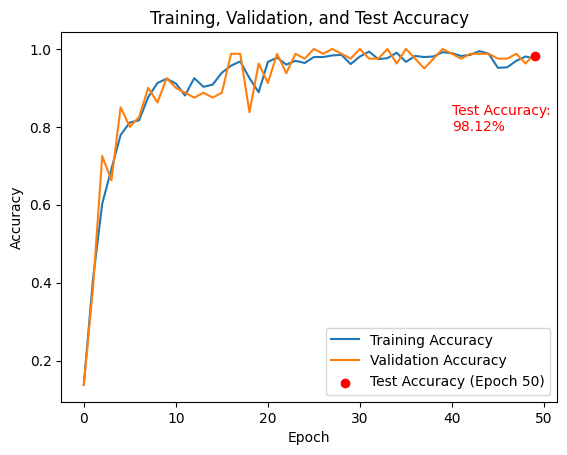

In [8]:
import matplotlib.pyplot as plt

# Assuming 'history' object after model.fit and test data available
epochs = 50

# Evaluate the model on test data to get the test accuracy
test_loss, test_accuracy = model.evaluate(test_ds)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Plot test accuracy at the final epoch (epoch 50)
plt.scatter(epochs - 1, test_accuracy, color='red', label='Test Accuracy (Epoch 50)', zorder=5)

# Add text annotation for test accuracy
plt.text(epochs - 10, test_accuracy - 0.2, f'Test Accuracy:\n{(test_accuracy * 100):.2f}%', 
         horizontalalignment='left', verticalalignment='bottom', color='red')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')

# Add legend and show the plot
plt.legend()
plt.show()


# Adding L2 regularization to the model to try to prevent overfitting 

In [9]:
from keras import regularizers

num_classes = 16
model_L2 = keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(num_classes)
])

model_L2.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [10]:
epochs = 50
history_L2 = model_L2.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0650 - loss: 2.9707 - val_accuracy: 0.1250 - val_loss: 2.6439
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2094 - loss: 2.4423 - val_accuracy: 0.1625 - val_loss: 2.2064
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3573 - loss: 1.8872 - val_accuracy: 0.5000 - val_loss: 1.6313
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5313 - loss: 1.4588 - val_accuracy: 0.5750 - val_loss: 1.1576
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5964 - loss: 1.1782 - val_accuracy: 0.6375 - val_loss: 1.1033
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6395 - loss: 1.0663 - val_accuracy: 0.6000 - val_loss: 0.9915
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7188 - loss: 0.8770 - val_accuracy: 0.8875 - val_loss: 0.5986
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7931 - loss: 0.6599 - val_accuracy: 0.8875 - v

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9800 - loss: 0.1479

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9690 - loss: 0.2326 


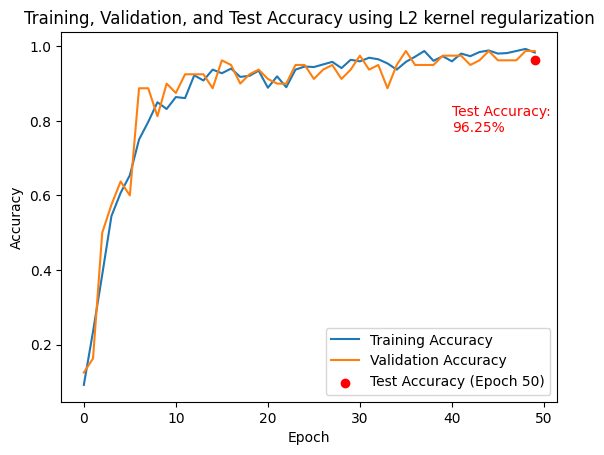

In [11]:
import matplotlib.pyplot as plt

# Assuming 'history' object after model.fit and test data available
epochs = 50

# Evaluate the model on test data to get the test accuracy
test_loss_l2, test_accuracy_l2 = model_L2.evaluate(test_ds)

# Plot training and validation accuracy
plt.plot(history_L2.history['accuracy'], label='Training Accuracy')
plt.plot(history_L2.history['val_accuracy'], label='Validation Accuracy')

# Plot test accuracy at the final epoch (epoch 50)
plt.scatter(epochs - 1, test_accuracy_l2, color='red', label='Test Accuracy (Epoch 50)', zorder=5)

# Add text annotation for test accuracy
plt.text(epochs - 10, test_accuracy_l2 - 0.2, f'Test Accuracy:\n{(test_accuracy_l2 * 100):.2f}%', 
         horizontalalignment='left', verticalalignment='bottom', color='red')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy using L2 kernel regularization')

# Add legend and show the plot
plt.legend()
plt.show()


# Adding Batch Normalization to the model to try to prevent overfitting 

In [21]:
num_classes = 16
model_batch = keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes)
])

model_batch.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [22]:
epochs = 50
history_batch = model_batch.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.3130 - loss: 2.4719 - val_accuracy: 0.0500 - val_loss: 2.8450
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6514 - loss: 1.1189 - val_accuracy: 0.0125 - val_loss: 2.8552
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7046 - loss: 0.9060 - val_accuracy: 0.1625 - val_loss: 3.0148
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8300 - loss: 0.6033 - val_accuracy: 0.1250 - val_loss: 3.5207
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9122 - loss: 0.4357 - val_accuracy: 0.1250 - val_loss: 4.3173
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9173 - loss: 0.3618 - val_accuracy: 0.1250 - val_loss: 5.0622
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9202 - loss: 0.3126 - val_accuracy: 0.1250 - val_loss: 5.8901
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9515 - loss: 0.2427 - val_accuracy: 0.1250 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0131 


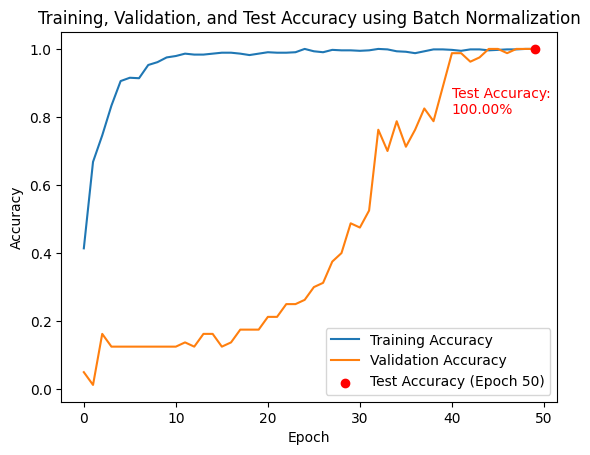

In [23]:
import matplotlib.pyplot as plt

# Assuming 'history' object after model.fit and test data available
epochs = 50

# Evaluate the model on test data to get the test accuracy
test_loss_batch, test_accuracy_batch = model_batch.evaluate(test_ds)

# Plot training and validation accuracy
plt.plot(history_batch.history['accuracy'], label='Training Accuracy')
plt.plot(history_batch.history['val_accuracy'], label='Validation Accuracy')

# Plot test accuracy at the final epoch (epoch 50)
plt.scatter(epochs - 1, test_accuracy_batch, color='red', label='Test Accuracy (Epoch 50)', zorder=5)

# Add text annotation for test accuracy
plt.text(epochs - 10, test_accuracy_batch - 0.2, f'Test Accuracy:\n{(test_accuracy_batch * 100):.2f}%', 
         horizontalalignment='left', verticalalignment='bottom', color='red')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy using Batch Normalization')

# Add legend and show the plot
plt.legend()
plt.show()
